
# Malicous URL Detection Model  

### Table of Contents 

1) Simple EDA and Data Classification  <br>
2) Data Pre-Processing <br>
3) Dealing with Class Imbalance <br>
4) Modelling <br> 
5) Result <br>
6) Limitations & Future Work

In [1]:
# Import relevent Libraries
import requests
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from io import StringIO
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from scipy import stats
#Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Additional Libraries and functions (For reports and PDF conversion) 
import pdfkit
import tempfile
from ydata_profiling import ProfileReport
from IPython.core.display import display, HTML

# Some settings for making the tables and the report look nicer
sns.set_theme()
%matplotlib inline
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 999)
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>.container { length:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')
# Set seed for repition 
np.random.seed(1)

/var/folders/hc/rv0ch5hn293cmmlwhw7w_drh0000gn/T/ipykernel_10909/2206543399.py:31: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Explanatory Data Analysis - EDA


To learn more about our data and to ore importantly to find a practical solution (not ML base), we use EDA to hopefully learn some patterns about the URLs in each class. <br> 

I have heard about some new automatic libraries in pandas which can get us started with EDA, so will be trying those out here. 

In [2]:
# Read in the data
df = pd.read_csv("../data/raw/malicious_phish.csv")

In [3]:
#URL_report = ProfileReport(df, title="URL Report", explorative=True)

In [4]:
#URL_report

In [5]:
# # Save the report to a HTML file
# URL_report.to_file("URL_Report")

# # Now save it into a PDF aswell
# # Save the report to a temporary HTML file
# temp_html_file = tempfile.NamedTemporaryFile(suffix=".html")
# URL_report.to_file(temp_html_file.name)

# # Convert the HTML to PDF
# pdf_file_path = "URL_Report.pdf"
# pdfkit.from_file(temp_html_file.name, pdf_file_path)

# # Close and delete the temporary HTML file
# temp_html_file.close()

In [6]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=com_content&view=article&id=70&vsig70_0=15,defacement
4,http://adventure-nicaragua.net/index.php?option=com_mailto&tmpl=component&link=aHR0cDovL2FkdmVudHVyZS1uaWNhcmFndWEubmV0L2luZGV4LnBocD9vcHRpb249Y29tX2NvbnRlbnQmdmlldz1hcnRpY2xlJmlkPTQ3OmFib3V0JmNhdGlkPTM2OmRlbW8tYXJ0aWNsZXMmSXRlbWlkPTU0,defacement


In [7]:
df.type.unique() # Benign is Good URLs (or NOT spam URLs)

array(['phishing', 'benign', 'defacement', 'malware'], dtype=object)

In [8]:
df.groupby('type').nunique() 

,url
type,
benign,428080
defacement,95308
malware,23645
phishing,94092


In [9]:
df.count()

url     651191
type    651191
dtype: int64

In [10]:
# Count duplicates in the 'url' column
duplicates_count = df.duplicated(subset=['url']).sum()

print(f"Number of duplicates in 'url' column: {duplicates_count}") # 10,000 urls are duplicated 

Number of duplicates in 'url' column: 10072


In [11]:
(651191 - 10072) / 651191

0.9845329557687376

### QUICK ANALYSIS FROM REPORT

We can see that due to the results from the report and some additional EDA, we notice quite a few things. <br>
I'll point out some of the key things I noticed which I will need to deal with later on in my data preprocessing and modelling. <br> 

- Firstly, we see a large class imbalance (as expected when dealing with fraud cases), as Benign Class has apprximately 428K rows and Fraud classes have: 95,000 defacement, 23,000 malware and 94,000 as phishing. <br>
- There is quite a few duplicate rows (10,000), so about 641119 distinct rows (98.5%) 
- From the sample rows, we can see the rows of different types are indeed different. Let's see if we can get that picked up. 

## Digging deeper to find more patterns about the bad urls for a heuristic classifier

In [12]:
good_urls = df[df['type'] == 'benign']
good_urls = list(df['url'])

In [13]:
# Get all good urls
good_urls = df[df['type'] == 'benign']
good_urls = list(good_urls['url'])
print(len(good_urls))

# print out some random good urls 
# initializing the value of n
n = 1
# printing 1 random url from list each time (too see the lenght of them mostly)
print("GOOD URLS") 
for i in range(10): # Change the range to see more urls
    random_good_url = str(random.sample(good_urls, n))
    print("Url size: ", len(random_good_url), random_good_url )

428103
GOOD URLS
Url size:  74 ['education.com/schoolfinder/us/california/oakland/fruitvale-elementary/']
Url size:  37 ['content.postnewsgroup.com/?p=2471']
Url size:  88 ['http://ap.org/Content/AP-In-The-News/2012/Burl-Osborne-former-chair-of-AP-board-dies']
Url size:  77 ['depaulbluedemons.com/sports/m-baskbl/spec-rel/depa-m-baskbl-spec-rel.html']
Url size:  128 ['tcm.com/this-month/movie-news.html?id=446215&name=A-Special-Screening-of-Rarely-Seen-Irish-Silent-Film-Guests-of-the-Nation-']
Url size:  79 ['plasamusic.com/mp3/joseph_vincent/1/-_jason_chen_best_love_song_lyrics.html']
Url size:  68 ['lawyers.com/Virginia/Richmond/David-Neal-Anthony-22449833-a.html']
Url size:  81 ['sfexaminer.com/local/2011/11/rally-occupies-bank-america-branch-san-francisco']
Url size:  25 ['forumjar.com/list/855']
Url size:  40 ['duckduckgo.com/1/c/French_historians']


In [14]:
# Get all bad urls
bad_urls = df[df['type'] != 'benign']
bad_urls = list(bad_urls['url'])
print(len(bad_urls))

# Print out some bad urls 
# initializing the value of n
n = 1
# printing 1 random url from list each time (too see the lenght of them mostly)
print("BAD URLS") 
for i in range(10): # Change the range to see more urls
    random_bad_url = str(random.sample(bad_urls, n))
    print("Url size: ", len(random_bad_url), random_bad_url )

223088
BAD URLS
Url size:  21 ['linuxcambodia.com']
Url size:  37 ['http://www.wsnc.org.au/markets/23']
Url size:  64 ['http://www.albondon.org/index.php/component/banners/click/17']
Url size:  131 ['http://www.fitnessequipmentworldok.com/exercise-bikes?page=shop.product_details&flypage=flypage.tpl&category_id=7&product_id=24']
Url size:  54 ['www.sei.cmu.edu/library/assets/jarvis-gristock.pdf']
Url size:  12 ['thisp.in']
Url size:  43 ['wellsfargo.secure.update.metrologpk.com']
Url size:  192 ['http://royalfarm-eg.com/index.php?option=com_mailto&tmpl=component&link=aHR0cDovL3JveWFsZmFybS1lZy5jb20vaW5kZXgucGhwP29wdGlvbj1jb21fazImdmlldz1pdGVtJmxheW91dD1pdGVtJmlkPTI2Jkl0ZW1pZD0yMDg=']
Url size:  121 ['http://jtbgreece.com/en/europe-short-escapes?page=shop.product_details&flypage=flypage.tpl&product_id=5&category_id=1']
Url size:  25 ['www.tin.org/docs.html']


# BAD URLS -- PATTERN #1

Every bad URL starts with starts with a "http:/", and not possibly "https:/" 

# BAD URLS -- PATTERN #2 

The length of bad urls is longer than the ones of the good URLs

In [15]:
df['url_length'] = df['url'].str.len()

In [16]:
df.head(10)

,url,type,url_length
0,br-icloud.com.br,phishing,16
1,mp3raid.com/music/krizz_kaliko.html,benign,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,31
3,http://www.garage-pirenne.be/index.php?option=com_content&view=article&id=70&vsig70_0=15,defacement,88
4,http://adventure-nicaragua.net/index.php?option=com_mailto&tmpl=component&link=aHR0cDovL2FkdmVudHVyZS1uaWNhcmFndWEubmV0L2luZGV4LnBocD9vcHRpb249Y29tX2NvbnRlbnQmdmlldz1hcnRpY2xlJmlkPTQ3OmFib3V0JmNhdGlkPTM2OmRlbW8tYXJ0aWNsZXMmSXRlbWlkPTU0,defacement,235
5,http://buzzfil.net/m/show-art/ils-etaient-loin-de-s-imaginer-que-le-hibou-allait-faire-ceci-quand-ils-filmaient-2.html,benign,118
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,45
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,46
8,http://www.pashminaonline.com/pure-pashminas,defacement,44
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,45


In [17]:
df.groupby(["type"]).mean()
# Therefore, the average length of good urls is approximately 58, and for bad urls it varies from 45-86. 

,url_length
type,
benign,57.675429
defacement,86.339395
malware,56.542958
phishing,45.858051


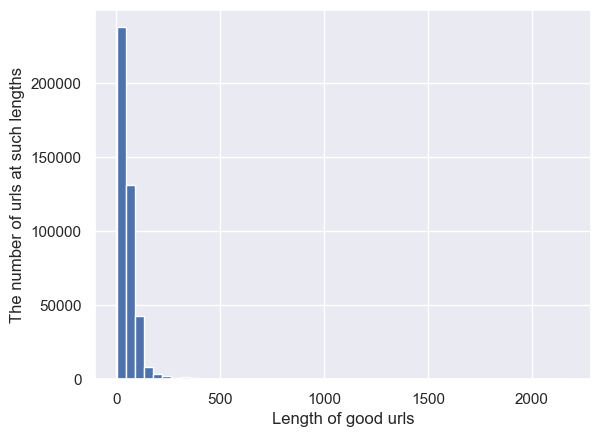

In [18]:
# Lets visualize this a bit
len_of_good_urls = [len(url) for url in good_urls]
len_of_bad_urls = [len(url) for url in bad_urls]

# plotting
plt.xlabel('Length of good urls')
plt.ylabel('The number of urls at such lengths')
plt.hist(len_of_good_urls, bins=50 )
plt.show() # It looks like most of the good urls are under the length of 100, with max length around 105. 

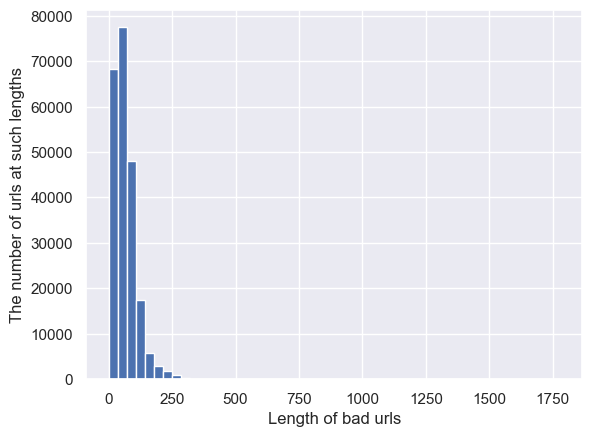

In [19]:
# plotting
plt.xlabel('Length of bad urls')
plt.ylabel('The number of urls at such lengths')
plt.hist(len_of_bad_urls, bins=50) 
plt.show() 
# It looks like most of the bad urls are more than length 90 or more.

In [20]:
# # Heuristic classifier
# def Heuristic_model(urls_df):
    
#     heuristic_df = {}
#     # Go thru urls and classify them as good or bad
#     for url in urls_df["url"]:
#         if url[0:5] == "http:":
#             if (len(url) > 100) or any(word in url for word in bad_words):
#                 heuristic_df[url] = 1
#             else:
#                 heuristic_df[url] = 0
#         else:
#             heuristic_df[url] = 0
#     #Turn it into a pandas df
#     df1 = pd.DataFrame.from_dict(heuristic_df, orient='index')
#     df1 = df1.reset_index()
#     df1.columns = ["url", "predicted_label"]
    
#     # inner join on the distinct urls to get the true labels
#     df1 = pd.merge(urls_df, df1, on=["url", "url"], how="inner")
    
#     return df1

In [21]:
# Heuristic_model = Heuristic_model(df) # We calculate the Precision, Recall, TP, FP, FN, etc at the end (below). 
# Heuristic_model

# ML Classifier Begins - Data Pre-Processing

In [22]:
print(len(df))
df.head(2)

651191


,url,type,url_length
0,br-icloud.com.br,phishing,16
1,mp3raid.com/music/krizz_kaliko.html,benign,35


In [23]:
# Drop duplicates - Since duplicates are only about 2% out of 600k rows, we can drop them. 
df = df.drop_duplicates()
len(df)

641125

###  Feature Engineering

After some research on a url, some of the features I have learned might be helpful are the following: <br>
- Length of the URL 
- Amount of Numbers in a URL
- Entropy of a URL
- NumParameters
- domain Extension
- amount of times %20 is present
- number of times @ is present
- if the url has an ip
- if the url has HTTP
- if the url has HTTPS
- if the url is live

These are the features we will try to create for our model. 


In [25]:
# Lets remove the url length we added and create a function for it below
df.drop(columns=['url_length'], inplace=True)

In [26]:
import whois
from datetime import datetime, timezone
import math
import pandas as pd
import numpy as np
from pyquery import PyQuery
from requests import get


In [27]:

class UrlFeaturizer(object):
    """
    UrlFeaturizer class is designed to extract various features from a given URL.
    These features include characteristics of the URL string itself, domain-specific attributes, and page features.
    """
    
    def __init__(self, url):
        self.url = url
        self.domain = url.split('//')[-1].split('/')[0]
        self.today = datetime.now().replace(tzinfo=None)

        try:
            self.whois = whois.query(self.domain).__dict__
        except:
            self.whois = None

        try:
            self.response = get(self.url)
            self.pq = PyQuery(self.response.text)
        except:
            self.response = None
            self.pq = None

    ## URL string Features
    def entropy(self):
        """
        Calculate the entropy of the URL string.
        """
        string = self.url.strip()
        prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
        entropy = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
        return entropy

    def ip(self):
        """
        Check if the URL contains an IP address.
        """
        string = self.url
        flag = False
        if ("." in string):
            elements_array = string.strip().split(".")
            if(len(elements_array) == 4):
                for i in elements_array:
                    if (i.isnumeric() and int(i)>=0 and int(i)<=255):
                        flag=True
                    else:
                        flag=False
                        break
        if flag:
            return 1 
        else:
            return 0

    def numDigits(self):
        """
        Count the number of digits in the URL
        """
        
        digits = [i for i in self.url if i.isdigit()]
        return len(digits)

    def urlLength(self):
        """
        Calculate the length of the URL
        """
        return len(self.url)

    def numParameters(self):
        """
        Count the number of parameters in the URL.
        """
        params = self.url.split('&')
        return len(params) - 1

    def numFragments(self):
        """
        Count the number of fragments in the URL
        """
        fragments = self.url.split('#')
        return len(fragments) - 1

    def numSubDomains(self):
        """
        Count the number of subdomains in the URL
        """
        subdomains = self.url.split('http')[-1].split('//')[-1].split('/')
        return len(subdomains)-1

    def domainExtension(self):
        ext = self.url.split('.')[-1].split('/')[0]
        return ext

    ## URL domain features
    def hasHttp(self):
        return 'http:' in self.url

    def hasHttps(self):
        return 'https:' in self.url

    def daysSinceRegistration(self):
        if self.whois and self.whois['creation_date']:
            diff = self.today - self.whois['creation_date'].replace(tzinfo=None)
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0

    def daysSinceExpiration(self):
        if self.whois and self.whois['expiration_date']:
            diff = self.whois['expiration_date'].replace(tzinfo=None) - self.today
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0
    
     ## URL Page Features
    def bodyLength(self):
        if self.pq is not None:
            return len(self.pq('html').text()) if self.urlIsLive else 0
        else:
            return 0

    def numTitles(self):
        if self.pq is not None:
            titles = ['h{}'.format(i) for i in range(7)]
            titles = [self.pq(i).items() for i in titles]
            return len([item for s in titles for item in s])
        else:
            return 0

    def numImages(self):
        if self.pq is not None:
            return len([i for i in self.pq('img').items()])
        else:
            return 0

    def numLinks(self):
        if self.pq is not None:
            return len([i for i in self.pq('a').items()])
        else:
            return 0

    def scriptLength(self):
        if self.pq is not None:
            return len(self.pq('script').text())
        else:
            return 0

    def specialCharacters(self):
        if self.pq is not None:
            bodyText = self.pq('html').text()
            schars = [i for i in bodyText if not i.isdigit() and not i.isalpha()]
            return len(schars)
        else:
            return 0

    def scriptToSpecialCharsRatio(self):
        v = self.specialCharacters()
        if self.pq is not None and v!=0:
            sscr = self.scriptLength()/v
        else:
            sscr = 0
        return sscr

    def scriptTobodyRatio(self):
        v = self.bodyLength()
        if self.pq is not None and v!=0:
            sbr = self.scriptLength()/v
        else:
            sbr = 0
        return sbr

    def bodyToSpecialCharRatio(self):
        v = self.bodyLength()
        if self.pq is not None and v!=0:
            bscr = self.specialCharacters()/v
        else:
            bscr = 0
        return bscr

    def urlIsLive(self):
        return self.response == 200

In [28]:
# def featurize_url(row):
#     featurizer = UrlFeaturizer(row['url'])
#     return {
#         'entropy': featurizer.entropy(),
#         'ip': featurizer.ip(),
#         'numDigits': featurizer.numDigits(),
#         'urlLength': featurizer.urlLength(),
#         'numParameters': featurizer.numParameters(),
#         'numFragments': featurizer.numFragments(),
#         'numSubDomains': featurizer.numSubDomains(),
#         'domainExtension': featurizer.domainExtension(),
#         'hasHttp': featurizer.hasHttp(),
#         'hasHttps': featurizer.hasHttps(),
#         'daysSinceRegistration': featurizer.daysSinceRegistration(),
#         'daysSinceExpiration': featurizer.daysSinceExpiration(),
#         'bodyLength': featurizer.bodyLength(),
#         'numTitles': featurizer.numTitles(),
#         'numImages': featurizer.numImages(),
#         'numLinks': featurizer.numLinks(),
#         'scriptLength': featurizer.scriptLength(),
#         'specialCharacters': featurizer.specialCharacters(),
#         'scriptToSpecialCharsRatio': featurizer.scriptToSpecialCharsRatio(),
#         'scriptTobodyRatio': featurizer.scriptTobodyRatio(),
#         'bodyToSpecialCharRatio': featurizer.bodyToSpecialCharRatio(),
#         'urlIsLive': featurizer.urlIsLive(),
#     }

# # Apply the function to each row of the DataFrame
# featurized_data = df.apply(featurize_url, axis=1)

# # Convert the resulting list of dictionaries into a DataFrame
# featurized_df = pd.DataFrame(featurized_data.tolist())

# # Concatenate the featurized DataFrame with the original DataFrame
# df = pd.concat([df, featurized_df], axis=1)


In [29]:
# The above takes a long time to run. 
# Lets pull in the clean data from here

cleaned_df = pd.read_csv('../data/processed/feature_data.csv')

In [30]:
cleaned_df

,Unnamed: 0,File,bodyLength,bscr,dse,dsr,entropy,ext,hasHttp,hasHttps,has_ip,numDigits,numImages,numLinks,numParams,numTitles,num_%20,num_@,sbr,scriptLength,specialChars,sscr,urlIsLive,urlLength
0,0,spam_dataset,31,0.064516,0,0,-4.708307,uk,True,False,0,27,1,0,0,0,0,0,0.000000,0,2,0.000000,False,81
1,1,spam_dataset,64790,0.306050,0,0,-4.576882,html,True,False,0,12,6,183,0,19,0,0,0.923800,59853,19829,3.018458,False,58
2,2,spam_dataset,757,0.195509,0,0,-4.205536,html,True,False,0,0,6,8,0,1,0,0,0.000000,0,148,0.000000,False,46
3,3,spam_dataset,266310,0.230915,0,0,-4.550931,html,True,False,0,13,3,831,0,648,0,0,0.312647,83261,61495,1.353947,False,52
4,4,spam_dataset,40,0.200000,0,0,-4.689336,php?cPath=193_195_197&products_id=1395&op=list,True,False,0,14,0,0,2,1,0,0,0.000000,0,8,0.000000,False,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54526,9996,Defacement,33,0.121212,0,0,-4.755244,tpl&product_id=336&option=com_virtuemart&Itemid=69,True,False,0,8,0,0,5,1,0,0,0.000000,0,4,0.000000,False,155
54527,9997,Defacement,862930,0.207603,0,0,-4.419173,html,True,False,0,6,2,22,0,3,0,0,0.011485,9911,179147,0.055323,False,79
54528,9998,Defacement,183,0.185792,0,0,-4.196164,com,True,False,0,3,0,0,0,1,0,0,0.000000,0,34,0.000000,False,65
54529,9999,Defacement,0,0.000000,0,0,-3.896292,jpg,True,False,0,2,0,0,0,0,0,0,0.000000,0,0,0.000000,False,28


In [31]:
# drop the 'Unnamed' column
cleaned_df = cleaned_df.drop(columns=['Unnamed: 0'])

In [32]:
cleaned_df

,File,bodyLength,bscr,dse,dsr,entropy,ext,hasHttp,hasHttps,has_ip,numDigits,numImages,numLinks,numParams,numTitles,num_%20,num_@,sbr,scriptLength,specialChars,sscr,urlIsLive,urlLength
0,spam_dataset,31,0.064516,0,0,-4.708307,uk,True,False,0,27,1,0,0,0,0,0,0.000000,0,2,0.000000,False,81
1,spam_dataset,64790,0.306050,0,0,-4.576882,html,True,False,0,12,6,183,0,19,0,0,0.923800,59853,19829,3.018458,False,58
2,spam_dataset,757,0.195509,0,0,-4.205536,html,True,False,0,0,6,8,0,1,0,0,0.000000,0,148,0.000000,False,46
3,spam_dataset,266310,0.230915,0,0,-4.550931,html,True,False,0,13,3,831,0,648,0,0,0.312647,83261,61495,1.353947,False,52
4,spam_dataset,40,0.200000,0,0,-4.689336,php?cPath=193_195_197&products_id=1395&op=list,True,False,0,14,0,0,2,1,0,0,0.000000,0,8,0.000000,False,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54526,Defacement,33,0.121212,0,0,-4.755244,tpl&product_id=336&option=com_virtuemart&Itemid=69,True,False,0,8,0,0,5,1,0,0,0.000000,0,4,0.000000,False,155
54527,Defacement,862930,0.207603,0,0,-4.419173,html,True,False,0,6,2,22,0,3,0,0,0.011485,9911,179147,0.055323,False,79
54528,Defacement,183,0.185792,0,0,-4.196164,com,True,False,0,3,0,0,0,1,0,0,0.000000,0,34,0.000000,False,65
54529,Defacement,0,0.000000,0,0,-3.896292,jpg,True,False,0,2,0,0,0,0,0,0,0.000000,0,0,0.000000,False,28


In [34]:
cleaned_df.groupby('File').nunique() 

,bodyLength,bscr,dse,dsr,entropy,ext,hasHttp,hasHttps,has_ip,numDigits,numImages,numLinks,numParams,numTitles,num_%20,num_@,sbr,scriptLength,specialChars,sscr,urlIsLive,urlLength
File,,,,,,,,,,,,,,,,,,,,,,
Benign_list_big_final,5011,5559,276,309,10502,1395,2,2,1,143,222,625,11,122,11,3,5004,3905,4455,5115,1,273
Defacement,1479,1656,1,1,8575,4923,1,1,1,57,88,184,12,52,1,1,1249,919,1157,1244,1,257
Malware_dataset,250,279,1,1,2487,419,2,2,1,76,25,67,12,18,4,2,205,148,236,223,1,182
phishing_dataset,1154,1294,618,1209,7953,720,2,2,1,107,55,156,14,42,8,3,889,764,914,873,1,241
spam_dataset,1375,1413,1,1,7464,5430,1,1,1,178,49,255,13,153,18,2,1385,336,1046,1248,1,448


In [33]:
cleaned_df

,File,bodyLength,bscr,dse,dsr,entropy,ext,hasHttp,hasHttps,has_ip,numDigits,numImages,numLinks,numParams,numTitles,num_%20,num_@,sbr,scriptLength,specialChars,sscr,urlIsLive,urlLength
0,spam_dataset,31,0.064516,0,0,-4.708307,uk,True,False,0,27,1,0,0,0,0,0,0.000000,0,2,0.000000,False,81
1,spam_dataset,64790,0.306050,0,0,-4.576882,html,True,False,0,12,6,183,0,19,0,0,0.923800,59853,19829,3.018458,False,58
2,spam_dataset,757,0.195509,0,0,-4.205536,html,True,False,0,0,6,8,0,1,0,0,0.000000,0,148,0.000000,False,46
3,spam_dataset,266310,0.230915,0,0,-4.550931,html,True,False,0,13,3,831,0,648,0,0,0.312647,83261,61495,1.353947,False,52
4,spam_dataset,40,0.200000,0,0,-4.689336,php?cPath=193_195_197&products_id=1395&op=list,True,False,0,14,0,0,2,1,0,0,0.000000,0,8,0.000000,False,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54526,Defacement,33,0.121212,0,0,-4.755244,tpl&product_id=336&option=com_virtuemart&Itemid=69,True,False,0,8,0,0,5,1,0,0,0.000000,0,4,0.000000,False,155
54527,Defacement,862930,0.207603,0,0,-4.419173,html,True,False,0,6,2,22,0,3,0,0,0.011485,9911,179147,0.055323,False,79
54528,Defacement,183,0.185792,0,0,-4.196164,com,True,False,0,3,0,0,0,1,0,0,0.000000,0,34,0.000000,False,65
54529,Defacement,0,0.000000,0,0,-3.896292,jpg,True,False,0,2,0,0,0,0,0,0,0.000000,0,0,0.000000,False,28


In [34]:
import pandas as pd

# Assuming cleaned_df is your DataFrame
replacement_dict = {
    'Benign_list_big_final': 'Benign',
    'Malware_dataset': 'Malware',
    'phishing_dataset': 'Phishing', 
    'spam_dataset': 'spam'
}

cleaned_df['File'] = cleaned_df['File'].replace(replacement_dict)

# Now, the specified values have been replaced in the 'File' column


In [35]:
cleaned_df.groupby('File').nunique() 

,bodyLength,bscr,dse,dsr,entropy,ext,hasHttp,hasHttps,has_ip,numDigits,numImages,numLinks,numParams,numTitles,num_%20,num_@,sbr,scriptLength,specialChars,sscr,urlIsLive,urlLength
File,,,,,,,,,,,,,,,,,,,,,,
Benign,5011,5559,276,309,10502,1395,2,2,1,143,222,625,11,122,11,3,5004,3905,4455,5115,1,273
Defacement,1479,1656,1,1,8575,4923,1,1,1,57,88,184,12,52,1,1,1249,919,1157,1244,1,257
Malware,250,279,1,1,2487,419,2,2,1,76,25,67,12,18,4,2,205,148,236,223,1,182
Phishing,1154,1294,618,1209,7953,720,2,2,1,107,55,156,14,42,8,3,889,764,914,873,1,241
spam,1375,1413,1,1,7464,5430,1,1,1,178,49,255,13,153,18,2,1385,336,1046,1248,1,448


In [36]:
# Creating a dictionary to map labels to encoded values
label_encoding = {
    'Benign': 0,
    'Defacement': 1,
    'Malware': 2,
    'Phishing': 3,
    'spam': 4
}

# Encoding the 'File' column
cleaned_df['File'] = cleaned_df['File'].map(label_encoding)
cleaned_df

,File,bodyLength,bscr,dse,dsr,entropy,ext,hasHttp,hasHttps,has_ip,numDigits,numImages,numLinks,numParams,numTitles,num_%20,num_@,sbr,scriptLength,specialChars,sscr,urlIsLive,urlLength
0,4,31,0.064516,0,0,-4.708307,uk,True,False,0,27,1,0,0,0,0,0,0.000000,0,2,0.000000,False,81
1,4,64790,0.306050,0,0,-4.576882,html,True,False,0,12,6,183,0,19,0,0,0.923800,59853,19829,3.018458,False,58
2,4,757,0.195509,0,0,-4.205536,html,True,False,0,0,6,8,0,1,0,0,0.000000,0,148,0.000000,False,46
3,4,266310,0.230915,0,0,-4.550931,html,True,False,0,13,3,831,0,648,0,0,0.312647,83261,61495,1.353947,False,52
4,4,40,0.200000,0,0,-4.689336,php?cPath=193_195_197&products_id=1395&op=list,True,False,0,14,0,0,2,1,0,0,0.000000,0,8,0.000000,False,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54526,1,33,0.121212,0,0,-4.755244,tpl&product_id=336&option=com_virtuemart&Itemid=69,True,False,0,8,0,0,5,1,0,0,0.000000,0,4,0.000000,False,155
54527,1,862930,0.207603,0,0,-4.419173,html,True,False,0,6,2,22,0,3,0,0,0.011485,9911,179147,0.055323,False,79
54528,1,183,0.185792,0,0,-4.196164,com,True,False,0,3,0,0,0,1,0,0,0.000000,0,34,0.000000,False,65
54529,1,0,0.000000,0,0,-3.896292,jpg,True,False,0,2,0,0,0,0,0,0,0.000000,0,0,0.000000,False,28


In [40]:
# Convert 'dsr' and 'dse' columns to timedelta objects
cleaned_df['dsr'] = pd.to_timedelta(cleaned_df['dsr'])
cleaned_df['dse'] = pd.to_timedelta(cleaned_df['dse'])

# Convert timedelta objects to float representing number of days
cleaned_df['dsr'] = cleaned_df['dsr'].dt.total_seconds() / (60 * 60 * 24)
cleaned_df['dse'] = cleaned_df['dse'].dt.total_seconds() / (60 * 60 * 24)

In [39]:
cleaned_df

,File,bodyLength,bscr,dse,dsr,entropy,ext,hasHttp,hasHttps,has_ip,numDigits,numImages,numLinks,numParams,numTitles,num_%20,num_@,sbr,scriptLength,specialChars,sscr,urlIsLive,urlLength
0,4,31,0.064516,0.0,0.0,-4.708307,uk,True,False,0,27,1,0,0,0,0,0,0.000000,0,2,0.000000,False,81
1,4,64790,0.306050,0.0,0.0,-4.576882,html,True,False,0,12,6,183,0,19,0,0,0.923800,59853,19829,3.018458,False,58
2,4,757,0.195509,0.0,0.0,-4.205536,html,True,False,0,0,6,8,0,1,0,0,0.000000,0,148,0.000000,False,46
3,4,266310,0.230915,0.0,0.0,-4.550931,html,True,False,0,13,3,831,0,648,0,0,0.312647,83261,61495,1.353947,False,52
4,4,40,0.200000,0.0,0.0,-4.689336,php?cPath=193_195_197&products_id=1395&op=list,True,False,0,14,0,0,2,1,0,0,0.000000,0,8,0.000000,False,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54526,1,33,0.121212,0.0,0.0,-4.755244,tpl&product_id=336&option=com_virtuemart&Itemid=69,True,False,0,8,0,0,5,1,0,0,0.000000,0,4,0.000000,False,155
54527,1,862930,0.207603,0.0,0.0,-4.419173,html,True,False,0,6,2,22,0,3,0,0,0.011485,9911,179147,0.055323,False,79
54528,1,183,0.185792,0.0,0.0,-4.196164,com,True,False,0,3,0,0,0,1,0,0,0.000000,0,34,0.000000,False,65
54529,1,0,0.000000,0.0,0.0,-3.896292,jpg,True,False,0,2,0,0,0,0,0,0,0.000000,0,0,0.000000,False,28


In [42]:
data = cleaned_df.copy()

In [43]:
# Maybe if we had more time, I can explore using NLP on the domain and subdomain features ( or some other form of label encoding
all_features =  data.drop(axis=1, labels =["ext"])
all_targets = all_features.pop("File")
train_features , test_features, train_targets, test_targets = train_test_split(all_features, all_targets, test_size=0.2)

## MODEL TRAINING

In [44]:
train_features

,bodyLength,bscr,dse,dsr,entropy,hasHttp,hasHttps,has_ip,numDigits,numImages,numLinks,numParams,numTitles,num_%20,num_@,sbr,scriptLength,specialChars,sscr,urlIsLive,urlLength
49260,0,0.000000,0.000000e+00,0.000000e+00,-4.076186,True,False,0,4,0,0,0,0,0,0,0.000000,0,0,0.000000,False,118
36962,0,0.000000,0.000000e+00,0.000000e+00,-4.885526,True,False,0,30,0,0,0,0,0,0,0.000000,0,0,0.000000,False,86
13443,78634,0.244551,0.000000e+00,0.000000e+00,-4.375626,True,False,0,6,5,46,0,6,0,0,0.447427,35183,19230,1.829589,False,104
19822,842,0.197150,3.078704e-12,2.650463e-11,-4.380920,True,False,0,1,0,2,0,9,0,0,0.000000,0,166,0.000000,False,108
21605,45841,0.243450,5.787037e-13,9.662037e-11,-4.344226,True,False,0,1,114,498,0,76,0,0,0.423464,19412,11160,1.739427,False,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50057,0,0.000000,0.000000e+00,0.000000e+00,-4.688154,True,False,0,5,0,0,5,0,0,0,0.000000,0,0,0.000000,False,129
32511,0,0.000000,0.000000e+00,0.000000e+00,-4.221049,True,False,0,11,0,0,0,0,0,0,0.000000,0,0,0.000000,False,39
5192,82,0.097561,0.000000e+00,0.000000e+00,-4.353266,True,False,0,0,0,0,0,0,0,0,0.000000,0,8,0.000000,False,63
12172,49,0.244898,0.000000e+00,0.000000e+00,-4.085043,True,False,0,28,0,0,0,1,0,0,0.000000,0,12,0.000000,False,96


In [45]:
train_targets

49260    1
36962    2
13443    0
19822    0
21605    0
        ..
50057    1
32511    3
5192     4
12172    0
33003    2
Name: File, Length: 43624, dtype: int64

In [46]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

# Initialize all models in a list
models = [#DecisionTreeClassifier(max_depth=8),
          # SVC is overfitting like crazy, needs regularization
          #SVC(C=1, decision_function_shape="ovo", verbose=True),
          RandomForestClassifier(max_depth=8, n_estimators=100),
          MLPClassifier(hidden_layer_sizes=(100,100),max_iter=1000,alpha=0.01,tol = 0.000000001, solver="lbfgs", verbose=False, activation = "relu"),
          AdaBoostClassifier(n_estimators=200, learning_rate=0.05),
          GaussianNB(),
          QuadraticDiscriminantAnalysis(reg_param=0),
          GradientBoostingClassifier(verbose=True),
         ]
# Define all the model names
model_names = [#"Decision Tree",
               #"SVC",
               "Random Forest",
               "Neural Net",
               "Adaboost",
               "Gaussian Naive Bayes",
               "QDA",
               "Gradient Boosting Classifier"
              ]
# Print the data size
print("Training Data size: {}".format(train_features.shape))

# Loop over models instead of having separate cell per model
for name, model in zip(model_names, models):
    # Training and model accuracy
    model.random_state = 0
    print("Training Model :  {}".format(name))
    model.fit(train_features, train_targets)
    print("Done Training {}".format(name))
    
    # Predict Y values
    y_pred = model.predict(test_features)
    
    # Calculate accuracy
    test_score = accuracy_score(test_targets, y_pred) * 100
    train_score = accuracy_score(train_targets, model.predict(train_features)) * 100
    
    # Calculate precision and recall for multi-class classification
    precision = precision_score(test_targets, y_pred, average='macro')
    recall = recall_score(test_targets, y_pred, average='macro')
    
    # Calculate the confusion matrix
    CM = confusion_matrix(test_targets, y_pred)
    
    # Print model scores and metrics
    print("{} Train Score : {:.2f}%".format(name, train_score))
    print("{} Test Score : {:.2f}%".format(name, test_score))
    print("Precision (macro-averaged): {:.2f}".format(precision))
    print("Recall (macro-averaged): {:.2f}".format(recall))
    print("Confusion Matrix:")
    print(CM)
    print("~"*50)
    print("Model Done")
    print("~"*50)


print("*"*50)    
print("~"*50)
print("ALL MODELS DONE")
print("~"*50)
print("*"*50)

Training Data size: (43624, 21)
Training Model :  Random Forest
Done Training Random Forest
Random Forest Train Score : 78.18%
Random Forest Test Score : 76.86%
Precision (macro-averaged): 0.76
Recall (macro-averaged): 0.76
Confusion Matrix:
[[1922   26   79  103   65]
 [  82 1313  108  355  174]
 [  44   41 1954   95   87]
 [ 112  261  203 1083  308]
 [  14  100  139  128 2111]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Model Done
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training Model :  Neural Net


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        12805     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24576D+00    |proj g|=  5.22640D+00

At iterate    1    f=  1.70775D+00    |proj g|=  9.65952D-01

At iterate    2    f=  1.58542D+00    |proj g|=  9.41570D-01

At iterate    3    f=  1.52604D+00    |proj g|=  1.23655D+00

At iterate    4    f=  1.50674D+00    |proj g|=  9.13670D-01

At iterate    5    f=  1.48234D+00    |proj g|=  5.86820D-01

At iterate    6    f=  1.46303D+00    |proj g|=  4.58717D-01

At iterate    7    f=  1.45967D+00    |proj g|=  2.55917D-01

At iterate    8    f=  1.44985D+00    |proj g|=  1.72571D+00

At iterate    9    f=  1.44809D+00    |proj g|=  6.87531D-01

At iterate   10    f=  1.44570D+00    |proj g|=  1.43439D+00

At iterate   11    f=  1.44451D+00    |proj g|=  5.19738D-01

At iterate   12    f=  1.44274D+00    |proj g|=  1.44789D+00

At iterate   13    f=  1.4

### CHOOSE THE BEST MODEL AND SAVE IT

It seems that from the above, RandomForest and GradientBoostingClassifier are performing the best out of the bat. <br>
Lets run them again but this time change some hyperparameters, and save these models for prediction later. 

In [49]:
!pip install joblib

In [51]:
import joblib

# Initialize all models in a list
models = [
    RandomForestClassifier(max_depth=16, n_estimators=200),
    GradientBoostingClassifier(verbose=True),
]

# Define all the model names
model_names = [
    "Random Forest",
    "Gradient Boosting Classifier"
]

# Initialize variables to store trained models
trained_rf_model = None
trained_gb_model = None

# Loop over models instead of having separate cell per model
for name, model in zip(model_names, models):
    # Training and model accuracy
    model.random_state = 0
    print("Training Model :  {}".format(name))
    model.fit(train_features, train_targets)
    print("Done Training {}".format(name))

    # Store trained models
    if name == "Random Forest":
        trained_rf_model = model
        # Save the Random Forest model
        joblib.dump(model, 'random_forest_model.pkl')
    elif name == "Gradient Boosting Classifier":
        trained_gb_model = model
        # Save the Gradient Boosting Classifier model
        joblib.dump(model, 'gradient_boosting_model.pkl')

    # Predict Y values
    y_pred = model.predict(test_features)

    # Calculate accuracy
    test_score = accuracy_score(test_targets, y_pred) * 100
    train_score = accuracy_score(train_targets, model.predict(train_features)) * 100

    # Calculate precision and recall for multi-class classification
    precision = precision_score(test_targets, y_pred, average='macro')
    recall = recall_score(test_targets, y_pred, average='macro')

    # Calculate the confusion matrix
    CM = confusion_matrix(test_targets, y_pred)

    # Print model scores and metrics
    print("{} Train Score : {:.2f}%".format(name, train_score))
    print("{} Test Score : {:.2f}%".format(name, test_score))
    print("Precision (macro-averaged): {:.2f}".format(precision))
    print("Recall (macro-averaged): {:.2f}".format(recall))
    print("Confusion Matrix:")
    print(CM)
    print("~" * 50)
    print("Model Done")
    print("~" * 50)

print("*" * 50)
print("~" * 50)
print("ALL MODELS DONE")
print("~" * 50)
print("*" * 50)

Training Model :  Random Forest
Done Training Random Forest
Random Forest Train Score : 91.60%
Random Forest Test Score : 88.69%
Precision (macro-averaged): 0.88
Recall (macro-averaged): 0.88
Confusion Matrix:
[[2118   16   14   40    7]
 [  33 1560   78  285   76]
 [   2    6 2138   50   25]
 [  34  142  156 1557   78]
 [   3   70   31   88 2300]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Model Done
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training Model :  Gradient Boosting Classifier
      Iter       Train Loss   Remaining Time 
         1           1.4638           24.64s
         2           1.3628           24.56s
         3           1.2837           24.37s
         4           1.2171           24.14s
         5           1.1655           24.00s
         6           1.1162           23.82s
         7           1.0792           23.56s
         8           1.0440           23.33s
         9           1.0127           23.05s
        10           0.9880           

In [52]:
# AS we can see, the models have been saved as .pkl files. 
!ls

UrlFeaturizer.py            random_forest_model.pkl
__pycache__                 sms-spam-detection.ipynb
featurizer.py               url_fraud_detection.ipynb
gradient_boosting_model.pkl url_processing.py


# ROUGH WORK BELOW

## TRYING OUT MULTIPROCESS AND THREADING TO SPEED UP PRE-PROCESSING

4 cores -> 48 seconds <br>
8 cores -> 34 seconds <br>
10 cores -> 32 seconds <br>

In [69]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.6 MB/s eta 0:00:0000:0100:05
  Preparing metadata (setup.py) ... done
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=5ba2d3cc176442f4dce08d418d8a8996286cb1097da2d6a64830257c13edff8b
  Stored in directory: /Users/tahir/Library/Caches/pip/wheels/92/09/11/aa01d01a7f005fda8a66ad71d2be7f8aa341bddafb27eee3c7
Successfully built pyspark


In [70]:
from pyspark.sql import SparkSession
from UrlFeaturizer import UrlFeaturizer

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("URLFeaturizer") \
    .getOrCreate()

# Sample DataFrame with URLs (100 rows)
df_subset = spark.createDataFrame(df.head(100))

# Define the number of partitions for parallel processing
num_partitions = 10

# Repartition DataFrame for parallel processing
df_subset = df_subset.repartition(num_partitions)

# Define featurize_url UDF
featurize_url_udf = udf(lambda url: featurize_url(url), returnType=MapType(StringType(), StringType()))

# Apply featurize_url UDF to DataFrame
featurized_df = df_subset.withColumn("featurized_data", featurize_url_udf("url"))

# Explode featurized_data column to create separate columns for features
featurized_df = featurized_df.selectExpr("*", "explode(featurized_data) as (feature, value)")

# Pivot the DataFrame to have features as columns
featurized_df = featurized_df.groupBy("url").pivot("feature").agg(first("value"))

# Show the resulting DataFrame
featurized_df.show()

# Stop SparkSession
spark.stop()


ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-102' coro=<TCPConnector._resolve_host() running at /opt/miniconda3/envs/warnify_ml/lib/python3.9/site-packages/aiohttp/connector.py:884> wait_for=<Future pending cb=[_chain_future.<locals>._call_check_cancel() at /opt/miniconda3/envs/warnify_ml/lib/python3.9/asyncio/futures.py:384, Task.__wakeup()]> cb=[shield.<locals>._inner_done_callback() at /opt/miniconda3/envs/warnify_ml/lib/python3.9/asyncio/tasks.py:890]>
ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-103' coro=<TCPConnector._resolve_host() running at /opt/miniconda3/envs/warnify_ml/lib/python3.9/site-packages/aiohttp/connector.py:884> wait_for=<Future pending cb=[_chain_future.<locals>._call_check_cancel() at /opt/miniconda3/envs/warnify_ml/lib/python3.9/asyncio/futures.py:384, Task.__wakeup()]> cb=[shield.<locals>._inner_done_callback() at /opt/miniconda3/envs/warnify_ml/lib/python3.9/asyncio/tasks.py:890]>
ER

NameError: name 'udf' is not defined

24/03/15 10:12:00 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [72]:
df_subset = df.head(100)

In [73]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType, IntegerType, FloatType, StructField, StructType
import time

# Define the schema for the resulting DataFrame
schema = StructType([
    StructField('url', StringType(), True),
    StructField('entropy', FloatType(), True),
    StructField('ip', IntegerType(), True),
    StructField('numDigits', IntegerType(), True),
    StructField('urlLength', IntegerType(), True),
    StructField('numParameters', IntegerType(), True),
    StructField('numFragments', IntegerType(), True),
    StructField('numSubDomains', IntegerType(), True),
    StructField('domainExtension', StringType(), True),
    StructField('hasHttp', IntegerType(), True),
    StructField('hasHttps', IntegerType(), True),
    StructField('daysSinceRegistration', StringType(), True),
    StructField('daysSinceExpiration', StringType(), True),
    StructField('bodyLength', IntegerType(), True),
    StructField('numTitles', IntegerType(), True),
    StructField('numImages', IntegerType(), True),
    StructField('numLinks', IntegerType(), True),
    StructField('scriptLength', IntegerType(), True),
    StructField('specialCharacters', IntegerType(), True),
    StructField('scriptToSpecialCharsRatio', FloatType(), True),
    StructField('scriptTobodyRatio', FloatType(), True),
    StructField('bodyToSpecialCharRatio', FloatType(), True),
    StructField('urlIsLive', IntegerType(), True),
])

# Initialize SparkSession
spark = SparkSession.builder.appName("URLFeaturization").getOrCreate()

# Sample DataFrame with URLs (100 rows)
# Assuming df_subset is already loaded as a pandas DataFrame
df_subset_spark = spark.createDataFrame(df_subset)

# Define the UDF
@udf(schema)
def featurize_url_udf(url):
    # Here you would call the original featurize_url function
    # Make sure to convert the result to a tuple with the same order as the schema
    result = featurize_url(url)
    return tuple(result.values())

# Start timing
start_time = time.time()

# Apply the UDF to the 'url' column and create a new DataFrame with the features
featurized_df_spark = df_subset_spark.withColumn("features", featurize_url_udf(col('url')))

# Show the result
featurized_df_spark.show()

# Calculate elapsed time
elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time, "seconds")

# Stop the SparkSession
spark.stop()


+--------------------+----------+--------------------+
|                 url|      type|            features|
+--------------------+----------+--------------------+
|    br-icloud.com.br|  phishing|{br-icloud.com.br...|
|mp3raid.com/music...|    benign|{mp3raid.com/musi...|
|bopsecrets.org/re...|    benign|{bopsecrets.org/r...|
|http://www.garage...|defacement|{http://www.garag...|
|http://adventure-...|defacement|{http://adventure...|
|http://buzzfil.ne...|    benign|{http://buzzfil.n...|
|espn.go.com/nba/p...|    benign|{espn.go.com/nba/...|
|yourbittorrent.co...|    benign|{yourbittorrent.c...|
|http://www.pashmi...|defacement|{http://www.pashm...|
|allmusic.com/albu...|    benign|{allmusic.com/alb...|
|corporationwiki.c...|    benign|{corporationwiki....|
|http://www.ikenmi...|defacement|{http://www.ikenm...|
|myspace.com/video...|    benign|{myspace.com/vide...|
|http://www.lebens...|defacement|{http://www.leben...|
|http://www.szabad...|defacement|{http://www.szaba...|
|http://la

In [67]:
from multiprocessing import Pool
import pandas as pd
from UrlFeaturizer import UrlFeaturizer, featurize_url

# Sample DataFrame with URLs (100 rows)
df_subset = df.head(100)

# Define the number of processes
num_processes = 10

# Split URLs for parallel processing
urls = df_subset['url'].tolist()

# Start timing
start_time = time.time()

# Initialize Pool for parallel processing
with Pool(num_processes) as pool:
    featurized_data = pool.map(featurize_url, urls)

# Convert the resulting list of dictionaries into a DataFrame
featurized_df = pd.DataFrame(featurized_data)

# Concatenate the featurized DataFrame with the original DataFrame
df_subset = pd.concat([df_subset, featurized_df], axis=1)

# Calculate elapsed time
elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time, "seconds")

# print(df_subset)


Elapsed Time: 32.6376051902771 seconds


In [ ]:
TRYING OUT MULTI THREADS

4 threads -> 42 seconds
8 threads -> 31 seconds
15 threads -> 32 seconds 

In [40]:
!pip install futures

  Preparing metadata (setup.py) ... done
  Created wheel for futures: filename=futures-3.0.5-py3-none-any.whl size=14068 sha256=192596ab11b022f214f69f210d3fe2847a2523426b07c381b48b86490b89b0d0
  Stored in directory: /Users/tahir/Library/Caches/pip/wheels/8a/4a/78/55bd408a487ca924f2053502beebf28862be93f14a1ba0a45c
Successfully built futures


In [47]:
!pip install aiohttp

  Using cached aiohttp-3.9.3-cp39-cp39-macosx_11_0_arm64.whl.metadata (7.4 kB)
  Using cached frozenlist-1.4.1-cp39-cp39-macosx_11_0_arm64.whl.metadata (12 kB)
  Using cached multidict-6.0.5-cp39-cp39-macosx_11_0_arm64.whl.metadata (4.2 kB)
  Using cached yarl-1.9.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (31 kB)
  Using cached async_timeout-4.0.3-py3-none-any.whl.metadata (4.2 kB)
Using cached aiohttp-3.9.3-cp39-cp39-macosx_11_0_arm64.whl (388 kB)
Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
Using cached async_timeout-4.0.3-py3-none-any.whl (5.7 kB)
Using cached frozenlist-1.4.1-cp39-cp39-macosx_11_0_arm64.whl (53 kB)
Using cached multidict-6.0.5-cp39-cp39-macosx_11_0_arm64.whl (30 kB)
Using cached yarl-1.9.4-cp39-cp39-macosx_11_0_arm64.whl (81 kB)


In [54]:
!pip install nest_asyncio

In [56]:
import nest_asyncio
nest_asyncio.apply()

In [60]:
import pandas as pd
from multiprocessing import Pool, cpu_count
from featurizer import featurize_batch
import time

# Sample DataFrame with URLs
df_subset = df.head(100)
urls = df_subset['url'].tolist()

# Define batch size
batch_size = 10

# Split URLs into batches
url_batches = [urls[i:i+batch_size] for i in range(0, len(urls), batch_size)]

# Get the number of CPU cores
num_processes = cpu_count()
print("Number of CPU cores available:", num_processes)

# Start timing
start_time = time.time()

# Initialize Pool for parallel processing
with Pool(num_processes) as pool:
    # Process batches in parallel
    batch_results = pool.map(featurize_batch, url_batches)

# Flatten the list of batch results
featurized_data = [item for sublist in batch_results for item in sublist]

# Convert the resulting list of dictionaries into a DataFrame
featurized_df = pd.DataFrame(featurized_data)

# Concatenate the featurized DataFrame with the original DataFrame
df_subset = pd.concat([df_subset, featurized_df], axis=1)

# Calculate elapsed time
elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time, "seconds")




Number of CPU cores available: 10
Elapsed Time: 41.778273820877075 seconds
                                                  url        type  \
0                                    br-icloud.com.br    phishing   
1                 mp3raid.com/music/krizz_kaliko.html      benign   
2                     bopsecrets.org/rexroth/cr/1.htm      benign   
3   http://www.garage-pirenne.be/index.php?option=...  defacement   
4   http://adventure-nicaragua.net/index.php?optio...  defacement   
5   http://buzzfil.net/m/show-art/ils-etaient-loin...      benign   
6       espn.go.com/nba/player/_/id/3457/brandon-rush      benign   
7      yourbittorrent.com/?q=anthony-hamilton-soulife      benign   
8        http://www.pashminaonline.com/pure-pashminas  defacement   
9       allmusic.com/album/crazy-from-the-heat-r16990      benign   
10  corporationwiki.com/Ohio/Columbus/frank-s-bens...      benign   
11  http://www.ikenmijnkunst.nl/index.php/expositi...  defacement   
12                     myspa

In [52]:
end_time = time.time()

In [44]:
import concurrent.futures
import pandas as pd
from UrlFeaturizer import UrlFeaturizer, featurize_url
import time

# Sample DataFrame with URLs (100 rows)
df_subset = df.head(100)

# Define the number of threads
num_threads = 15

# Split URLs for concurrent processing
urls = df_subset['url'].tolist()

# Start timing
start_time = time.time()

# Initialize ThreadPoolExecutor for concurrent processing
with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    featurized_data = executor.map(featurize_url, urls)

# Convert the resulting list of dictionaries into a DataFrame
featurized_df = pd.DataFrame(featurized_data)

# Concatenate the featurized DataFrame with the original DataFrame
df_subset = pd.concat([df_subset, featurized_df], axis=1)

# Calculate elapsed time
elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time, "seconds")


Elapsed Time: 31.292738676071167 seconds


In [ ]:
import pandas as pd
from UrlFeaturizer import UrlFeaturizer, featurize_url
from url_processing import process_url_chunk
import time
import multiprocessing

# Sample DataFrame with URLs (100 rows)
df_subset = df.head(100)

# Define the number of processes and threads per process
num_processes = 8
num_threads_per_process = 8

# Split URLs for parallel processing
urls = df_subset['url'].tolist()

# Start timing
start_time = time.time()

# Split the URLs into chunks for parallel processing
url_chunks = [urls[i:i + len(urls) // num_processes] for i in range(0, len(urls), len(urls) // num_processes)]

# Initialize Pool for parallel processing
with multiprocessing.Pool(num_processes) as pool:
    featurized_data_chunks = pool.map(process_url_chunk, url_chunks)

# Concatenate the featurized data from all chunks
featurized_data = [item for sublist in featurized_data_chunks for item in sublist]

# Convert the resulting list of dictionaries into a DataFrame
featurized_df = pd.DataFrame(featurized_data)

# Concatenate the featurized DataFrame with the original DataFrame
df_subset = pd.concat([df_subset, featurized_df], axis=1)

# Calculate elapsed time
elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time, "seconds")


In [ ]:
import multiprocessing

start = time.time()
def featurize_url_multiprocessing(row):
    featurizer = UrlFeaturizer(row['url'])
    return {
        'entropy': featurizer.entropy(),
        'ip': featurizer.ip(),
        'numDigits': featurizer.numDigits(),
        'urlLength': featurizer.urlLength(),
        'numParameters': featurizer.numParameters(),
        'numFragments': featurizer.numFragments(),
        'numSubDomains': featurizer.numSubDomains(),
        'domainExtension': featurizer.domainExtension(),
        'hasHttp': featurizer.hasHttp(),
        'hasHttps': featurizer.hasHttps(),
        'daysSinceRegistration': featurizer.daysSinceRegistration(),
        'daysSinceExpiration': featurizer.daysSinceExpiration(),
        'bodyLength': featurizer.bodyLength(),
        'numTitles': featurizer.numTitles(),
        'numImages': featurizer.numImages(),
        'numLinks': featurizer.numLinks(),
        'scriptLength': featurizer.scriptLength(),
        'specialCharacters': featurizer.specialCharacters(),
        'scriptToSpecialCharsRatio': featurizer.scriptToSpecialCharsRatio(),
        'scriptTobodyRatio': featurizer.scriptTobodyRatio(),
        'bodyToSpecialCharRatio': featurizer.bodyToSpecialCharRatio(),
        'urlIsLive': featurizer.urlIsLive(),
    }

# Define a function to process rows using multiprocessing
def process_rows_multiprocessing(data):
    with multiprocessing.Pool() as pool:
        results = pool.map(featurize_url_multiprocessing, data)
    return results

# Split the DataFrame into chunks to distribute the workload
chunk_size = len(df) // multiprocessing.cpu_count()
data_chunks = [df.iloc[i:i+chunk_size] for i in range(0, len(df), chunk_size)]

# Apply multiprocessing to process each chunk of data
results_multiprocessing = []
for chunk in data_chunks:
    results_multiprocessing.append(process_rows_multiprocessing(chunk))

# Flatten the results and concatenate them into a single DataFrame
featurized_data_multiprocessing = [item for sublist in results_multiprocessing for item in sublist]
featurized_df_multiprocessing = pd.DataFrame(featurized_data_multiprocessing)

# Concatenate the featurized DataFrame with the original DataFrame
df = pd.concat([df, featurized_df_multiprocessing], axis=1)
end = time.time()

In [ ]:
print("Total time:", start - end)

In [ ]:

def featurize_url(row):
    featurizer = UrlFeaturizer(row['url'])
    return {
        'entropy': featurizer.entropy(),
        'ip': featurizer.ip(),
        'numDigits': featurizer.numDigits(),
        'urlLength': featurizer.urlLength(),
        'numParameters': featurizer.numParameters(),
        'numFragments': featurizer.numFragments(),
        'numSubDomains': featurizer.numSubDomains(),
        'domainExtension': featurizer.domainExtension(),
        'hasHttp': featurizer.hasHttp(),
        'hasHttps': featurizer.hasHttps(),
        'daysSinceRegistration': featurizer.daysSinceRegistration(),
        'daysSinceExpiration': featurizer.daysSinceExpiration(),
        'bodyLength': featurizer.bodyLength(),
        'numTitles': featurizer.numTitles(),
        'numImages': featurizer.numImages(),
        'numLinks': featurizer.numLinks(),
        'scriptLength': featurizer.scriptLength(),
        'specialCharacters': featurizer.specialCharacters(),
        'scriptToSpecialCharsRatio': featurizer.scriptToSpecialCharsRatio(),
        'scriptTobodyRatio': featurizer.scriptTobodyRatio(),
        'bodyToSpecialCharRatio': featurizer.bodyToSpecialCharRatio(),
        'urlIsLive': featurizer.urlIsLive(),
    }

# Apply the function to each row of the DataFrame
featurized_data = df.apply(featurize_url, axis=1)

# Convert the resulting list of dictionaries into a DataFrame
featurized_df = pd.DataFrame(featurized_data.tolist())

# Concatenate the featurized DataFrame with the original DataFrame
df = pd.concat([df, featurized_df], axis=1)


In [75]:
# Assuming df is your pandas DataFrame
# Define a function to apply the featurizer methods to each row of the DataFrame
import time as t
def featurize_url(row):
    
    featurizer = UrlFeaturizer(row['url'])
    
    start_time = time.time()
    featurizer.entropy()
    end_time = t.time()
    entropy = [end_time - start_time]
    print(" ") 

    start_time = time.time()
    featurizer.ip()
    end_time = time.time()
    print("ip:", end_time - start_time)
    print(" ") 

    
    start_time = time.time()
    featurizer.numDigits()
    end_time = time.time()
    print("numDigits:", end_time - start_time)
    print(" ") 

    
    start_time = time.time()
    featurizer.urlLength()
    end_time = time.time()
    print("urlLength:", end_time - start_time)
    print(" ") 

    
    start_time = time.time()
    featurizer.numParameters()
    end_time = time.time()
    print("numParameters:", end_time - start_time)
    print(" ") 

    
    start_time = time.time()
    featurizer.numSubDomains()
    end_time = time.time()
    print("numSubDomains:", end_time - start_time)
    print(" ") 

    
    start_time = time.time()
    featurizer.domainExtension()
    end_time = time.time()
    print("domainExtension:", end_time - start_time)
    print(" ") 


    
    start_time = time.time()
    featurizer.numFragments()
    end_time = time.time()
    print("numFragments:", end_time - start_time)
    print(" ") 


    
    start_time = time.time()
    featurizer.hasHttp()
    end_time = time.time()
    print("hasHttp:", end_time - start_time)
    print(" ") 

    
    start_time = time.time()
    featurizer.numTitles()
    end_time = time.time()
    print("numTitles:", end_time - start_time)
    print(" ") 

    
    start_time = time.time()
    featurizer.daysSinceRegistration()
    end_time = time.time()
    print("daysSinceRegistration:", end_time - start_time)
    print(" ") 

    
    start_time = time.time()
    featurizer.numImages()
    end_time = time.time()
    print("numImages:", end_time - start_time)
    print(" ") 


    
    start_time = time.time()
    featurizer.bodyLength()
    end_time = time.time()
    print("bodyLength:", end_time - start_time)
    print(" ") 

    
    start_time = time.time()
    featurizer.numLinks()
    end_time = time.time()
    print("numLinks:", end_time - start_time)
    print(" ") 

    
    start_time = time.time()
    featurizer.specialCharacters()
    end_time = time.time()
    print("specialCharacters:", end_time - start_time)
    print(" ") 

    
    start_time = time.time()
    featurizer.scriptLength()
    end_time = time.time()
    print("scriptLength:", end_time - start_time)
    print(" ") 


    
    start_time = time.time()
    featurizer.scriptToSpecialCharsRatio()
    end_time = time.time()
    print("scriptToSpecialCharsRatio:", end_time - start_time)
    print(" ") 

    start_time = time.time()
    featurizer.bodyToSpecialCharRatio()
    end_time = time.time()
    print("bodyToSpecialCharRatio:", end_time - start_time)
    print(" ") 

    start_time = time.time()
    featurizer.urlIsLive()
    end_time = time.time()
    print("urlIsLive:", end_time - start_time)
    print(" ") 

    start_time = time.time()
    featurizer.scriptTobodyRatio()
    end_time = time.time()
    print("scriptTobodyRatio:", end_time - start_time)
    print(" ") 

    return None


In [86]:
# Execution times data
execution_times = {
    "entropy": [3.4809112548828125e-05, 2.7894973754882812e-05, 1.7881393432617188e-05, 0.00012969970703125, 3.790855407714844e-05, 6.508827209472656e-05, 7.796287536621094e-05, 6.985664367675781e-05],
    "ip": [3.0994415283203125e-06, 1.9073486328125e-06, 1.9073486328125e-06, 5.0067901611328125e-06, 1.9073486328125e-06, 7.867813110351562e-06, 4.0531158447265625e-06, 4.0531158447265625e-06],
    "numDigits": [5.245208740234375e-06, 3.814697265625e-06, 2.1457672119140625e-06, 4.601478576660156e-05, 5.7220458984375e-06, 1.5020370483398438e-05, 4.0531158447265625e-06, 1.0967254638671875e-05],
    "urlLength": [7.152557373046875e-07, 9.5367431640625e-07, 0.0, 3.0994415283203125e-06, 2.1457672119140625e-06, 2.86102294921875e-06, 1.9073486328125e-06, 1.9073486328125e-06],
    "numParameters": [9.5367431640625e-07, 9.5367431640625e-07, 0.0, 4.76837158203125e-06, 4.0531158447265625e-06, 5.245208740234375e-06, 1.9073486328125e-06, 2.1457672119140625e-06],
    "numSubDomains": [4.0531158447265625e-06, 1.9073486328125e-06, 2.1457672119140625e-06, 7.152557373046875e-06, 7.152557373046875e-06, 7.3909759521484375e-06, 2.1457672119140625e-06, 3.814697265625e-06],
    "domainExtension": [3.0994415283203125e-06, 1.1920928955078125e-06, 1.9073486328125e-06, 5.7220458984375e-06, 5.0067901611328125e-06, 3.814697265625e-06, 1.9073486328125e-06, 4.0531158447265625e-06],
    "numFragments": [9.5367431640625e-07, 9.5367431640625e-07, 1.1920928955078125e-06, 3.0994415283203125e-06, 3.814697265625e-06, 3.0994415283203125e-06, 1.1920928955078125e-06, 2.1457672119140625e-06],
    "hasHttp": [9.5367431640625e-07, 7.152557373046875e-07, 0.0, 2.86102294921875e-06, 1.6689300537109375e-06, 9.5367431640625e-07, 0.0, 9.5367431640625e-07],
    "numTitles": [2.1457672119140625e-06, 9.5367431640625e-07, 9.5367431640625e-07, 0.0027511119842529297, 3.0994415283203125e-06, 3.814697265625e-06, 9.5367431640625e-07, 1.9073486328125e-06],
    "daysSinceRegistration": [1.1920928955078125e-05, 0.0, 9.5367431640625e-07, 3.0994415283203125e-06, 3.0994415283203125e-06, 3.0994415283203125e-06, 9.5367431640625e-07, 1.9073486328125e-06],
    "numImages": [9.5367431640625e-07, 1.1920928955078125e-06, 1.1920928955078125e-06, 6.914138793945312e-05, 3.0994415283203125e-06, 2.86102294921875e-06, 9.5367431640625e-07, 2.1457672119140625e-06],
    "bodyLength": [9.5367431640625e-07, 1.1920928955078125e-06, 9.5367431640625e-07, 0.0008339881896972656, 3.814697265625e-06, 1.1920928955078125e-06, 9.5367431640625e-07, 1.1920928955078125e-06],
    "numLinks": [1.1920928955078125e-06, 0.0, 9.5367431640625e-07, 0.00015687942504882812, 2.86102294921875e-06, 4.0531158447265625e-06, 9.5367431640625e-07, 7.152557373046875e-07],
    "specialCharacters": [9.5367431640625e-07, 9.5367431640625e-07, 0.0, 0.0013680458068847656, 4.291534423828125e-06, 0.0, 9.5367431640625e-07, 0.0],
    "scriptLength": [9.5367431640625e-07, 0.0, 9.5367431640625e-07, 0.00015497207641601562, 3.0994415283203125e-06, 9.5367431640625e-07, 9.5367431640625e-07, 9.5367431640625e-07],
    "scriptToSpecialCharsRatio": [1.9073486328125e-06, 1.1920928955078125e-06, 9.5367431640625e-07, 0.001477956771850586, 4.0531158447265625e-06, 2.1457672119140625e-06, 1.1920928955078125e-06, 2.1457672119140625e-06],
    "bodyToSpecialCharRatio": [2.1457672119140625e-06, 9.5367431640625e-07, 0.0, 0.0019032955169677734, 4.0531158447265625e-06, 1.9073486328125e-06, 4.76837158203125e-06, 1.9073486328125e-06],
    "urlIsLive": [9.5367431640625e-07, 0.0, 1.1920928955078125e-06, 1.9073486328125e-06, 1.9073486328125e-06, 2.86102294921875e-06, 9.5367431640625e-07, 2.1457672119140625e-06],
    "scriptTobodyRatio": [1.1920928955078125e-06, 3.0994415283203125e-06, 2.1457672119140625e-06, 0.00144195556640625, 2.1457672119140625e-06, 2.1457672119140625e-06, 1.9073486328125e-06, 2.1457672119140625e-06]
}

# Calculate average execution time for each method
average_execution_times = {method: sum(times) / len(times) for method, times in execution_times.items()}

# Sort the methods by their average execution times in descending order
sorted_methods = sorted(average_execution_times.items(), key=lambda x: x[1], reverse=True)

# Select the top 3 longest methods
top_3_longest_methods = sorted_methods[:3]

# Print the top 3 longest methods and their average execution times
for method, avg_time in top_3_longest_methods:
    print(f"{method}: {avg_time}")


numTitles: 0.00034561753273010254
bodyToSpecialCharRatio: 0.00023987889289855957
scriptToSpecialCharsRatio: 0.00018644332885742188


In [87]:
# Find the top 3 maximum execution times and their corresponding features
top_3_max_values = []

for method, times in execution_times.items():
    max_time = max(times)
    top_3_max_values.append((method, max_time))

# Sort the top 3 maximum values in descending order
top_3_max_values = sorted(top_3_max_values, key=lambda x: x[1], reverse=True)[:3]

# Print the top 3 maximum values and their corresponding features
for method, max_time in top_3_max_values:
    print(f"Feature: {method}, Max Execution Time: {max_time}")


Feature: numTitles, Max Execution Time: 0.0027511119842529297
Feature: bodyToSpecialCharRatio, Max Execution Time: 0.0019032955169677734
Feature: scriptToSpecialCharsRatio, Max Execution Time: 0.001477956771850586


In [53]:
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Execution time: -6.137627124786377 seconds


In [88]:
# Create the features
import math
def url_length(url):
    return len(url)

def nums_in_url(url):
    # Get all digits inside of the url and store it ina list
    digits = [i for i in url if i.isdigit()]
    return len(digits)

def url_entropy(url):
    url = url.strip()
    prob = [float(url.count(c)) / len(url) for c in dict.fromkeys(list(url))]
    entropy = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
    return entropy

def num_parameters(url):
    params = url.split('&')
    return (len(params) - 1)

def num_Fragments(url):
    fragments = url.split('#')
    return len(fragments) - 1

def domain(url):
    domain = url.split('//')[-1].split('/')[0]
    return domain

def num_sub_domain(url):
    subdomains = url.split('http')[-1].split('//')[-1].split('/')
    return len(subdomains)-1

def domain_extension(url):
    domain = url.split('//')[-1].split('/')[0]
    ext = url.split('.')[-1].split('/')[0]
    return ext

def num_perecent20(url):
    return url.count("%20")

def num_AT_present(url):
    return url.count("@")

def url_has_http(url):
    return 'http:' in url

def url_has_https(url):
    return 'https:' in url

def url_contains_bad_words(url):
    # Define words which are in bad urls
    bad_words = ["client_id", "signin", "logon", "login", "authorize", "admin"]
    # Check if any of the words in the bad_words list are inside of that url
    if any(word in url for word in bad_words):
        return True
    else:
        return False

In [89]:
# Featurize the urls 
def featurize_urls(url_dataset):
    dict1 = {}
    for row in url_dataset["url"]:
        dict1[row] = [url_length(row), nums_in_url(row), url_entropy(row),num_parameters(row), num_Fragments(row), domain(row), num_sub_domain(row), domain_extension(row), 
                      num_perecent20(row), num_AT_present(row), url_has_http(row), url_has_https(row),url_contains_bad_words(row)]
    
    # Create it in a pandas dataframe
    df2 = pd.DataFrame.from_dict(dict1, orient='index')
    df2 = df2.reset_index()
    df2.columns =["url", 'url_length',"nums_in_url", "url_entropy", "num_parameters", "num_Fragments","domain", "num_sub_domain", "domain_extension", 
                  "num_perecent20", "num_AT_present",'num_http', 'num_https', 'has_bad_words']
    
    # inner join on the distinct urls to get the labels
    df2 = pd.merge(url_dataset, df2, on=["url", "url"], how="inner")
    return df2

In [38]:
# Maybe if we had more time, I can explore using NLP on the domain and subdomain features ( or some other form of label encoding
all_features = data.drop(axis=1, labels =["url", "domain", "domain_extension"])
all_targets = all_features.pop("label")
train_features , test_features, train_targets, test_targets = train_test_split(all_features, all_targets, test_size=0.2)

In [39]:
# import imbalance data library
from imblearn.over_sampling import SMOTE
from collections import Counter
smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(train_features, train_targets)

# Added approx. 6k more training examples! (for fruadulent rows)
print('Original dataset shape', Counter(train_targets))
print('Resample dataset shape', Counter(y_smote))

# WE use the resampled dataset for training. 
# NOTE that the testing data has not been changed.
train_features, train_targets = x_smote, y_smote

Original dataset shape Counter({0: 6276, 1: 570})
Resample dataset shape Counter({0: 6276, 1: 6276})


# Modelling & Training

## Conclusion and Limitations

Thank you so much for the oppurtunity to participate in this. 
If I had more time, I would have loved to do some of the following: <br>
- Explore more into the synthetic examples made to up the "bad" class.
- I also would have tried to increase the non-ml made model accuracy by adding more patterns such as seeing if a link is live (by checking if theres a response signal), and more. 
- Do some more feature engineering, and Tune the ML models more with grid search to find the best possible parameters.
- Maybe explore baysian optimization to see if error is really as low as possible
<br>

Other than that, we can see the random forest classifier and GB had the most amount of success. 
I would have also loved to do an ensemble of the top 3 models and present that as the main model solution, 
just to lower the chances of false positives as much as possible.<br> 
Thank you once again for the great oppurtunity! 